Import libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy import stats
import math
import pandas as pd
#import ipywidgets
from scipy.optimize import curve_fit
#import plotly.express as px
from numpy import mean, std

#from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, scale_x_continuous, scale_y_continuous
#from plotnine.data import mpg

Import data paths

#### 0 - Select specific columns

In [7]:
def clean_data(datam):
    try:
        datam["delayS"]=datam["delay"]/1000
    except KeyError:
        pass
    datam["pTemporalError"]=datam["perceivedTime"]-datam["target.started"]# Calculate temporalError
    datam["pTemporalErrorMs"]=datam["pTemporalError"]*1000
    try:   
        datam["physicalDelay"]=datam["distractor.started"]-datam["target.started"]
    except KeyError: 
        pass
    datam["physicalDelayMs"]=datam["physicalDelay"]*1000
    datam["rt_total"]=datam["responsePointer.stopped"]-datam["responsePointer.started"]
    #except KeyError:
        #print("already cleaned "+str(datam["date"][0]))
    return datam


#### Find outliers  and predicted perceived time 


In [195]:
xAxisTicks=[-0.300 , -0.233, -0.167, -0.100 , -0.033, 0.033, 0.100 ,0.167, 0.233, 0.300]
def outlier_remover(data,variable):
    #mean_tmp, std_tmp=data[variable].median(), data[variable].std()
    
    rows_to_delete= data[np.abs(data[variable])>1].index
    #rows_to_delete_lower = data[data["pTemporalError"]<0.75].index

    #rows_to_delete_upper = data[data["pTemporalError"]>1].index
    data = data.drop(rows_to_delete)
    """
    #data = data.drop(rows_to_delete_upper)
    
    q1, q3= np.percentile(data["pTemporalError"],[5,95])
    iqr = q3 - q1
    mean_tmp, std_tmp=data["pTemporalError"].mean(), data["pTemporalError"].std()

    rows_to_delete_lower = data[data["pTemporalError"]<mean_tmp-2*std_tmp].index
    data = data.drop(rows_to_delete_lower)

    rows_to_delete_upper = data[data["pTemporalError"]>mean_tmp+2*std_tmp].index

    #rows_to_delete_lower = data[data["pTemporalError"]<q1].index
    #rows_to_delete_upper = data[data["pTemporalError"]>q3].index
    
    data = data.drop(rows_to_delete_upper)
    """
    ####
    threshold=2
    # Calculate median absolute deviation (MAD)
    median = np.median(data[variable])
    abs_deviations = np.abs(data[variable] - median)
    mad = np.median(abs_deviations)

    # Define the upper and lower threshold
    upper_threshold = median + threshold * mad
    lower_threshold = median - threshold * mad

    # Remove outliers based on MAD
    mask_lower = data[variable] >= lower_threshold
    mask_upper = data[variable] <= upper_threshold
    data = data[mask_lower & mask_upper]

    
    return data
def clean_na(dfo):
    dfo=dfo[dfo["perceivedTime"].notna()]
    dfo=dfo[dfo["target.started"].notna()]
    dfo=dfo[dfo["pTemporalError"].notna()]
    unique_delays=dfo["delayS"].unique()
    dfo_tmp = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"])
    
    if len(unique_delays)>8:
        for i in unique_delays:
            dfo_tmp_0=outlier_remover(dfo[dfo["delayS"]==i],"pTemporalError")
            dfo_tmp = pd.concat([dfo_tmp, dfo_tmp_0], ignore_index=True)
        dfo=dfo_tmp
    else:
        dfo=outlier_remover(dfo,"pTemporalError")
    
    return dfo
def modelPerceivedTime(targetTime,alpha,beta):
    #return alpha*(np.sin(math.pi*x))+beta*x
    y=[alpha*(np.sin(math.pi*x))+beta*x for x in targetTime]
    return y
def modelPerceivedTime2(x,alpha,beta):
    #return alpha*(np.sin(math.pi*x))+beta*x
    return alpha*(np.sin(math.pi*x))+beta*x

def predictedPerceivedTime(dfo): 
    #df=df[df["isTrial"]=="trial"]
    # dfo=dfo[dfo["perceivedTime"].notna()]
    # dfo=dfo[dfo["target.started"].notna()]
    # dfo=dfo[dfo["pTemporalError"].notna()]
    # dfo=outlier_remover(dfo,"pTemporalError")
    # fit training
    x=np.float64(dfo["target.started"])
    y=np.float64(dfo["perceivedTime"])
    params_train, covariance_train = curve_fit(modelPerceivedTime2, x, y)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], params_train[0], params_train[1])
    ## assign new variables to df
    dfo["predictedPerceivedTime"]=modelPreditcedPerceivedTime # take fitted perceived time to the data
    dfo["pTemporalErrorFitted"]=dfo["perceivedTime"]-dfo["predictedPerceivedTime"] # calculate temporal error based on predicted time
    dfo["pTemporalErrorFitted"]=dfo["pTemporalErrorFitted"]-mean(dfo["pTemporalErrorFitted"])
    return dfo,params_train,covariance_train

def fitPerceivedTime(dfo):
    x=np.float64(dfo["target.started"])
    y=np.float64(dfo["perceivedTime"])
    params_train, covariance_train = curve_fit(modelPerceivedTime2, x, y)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], params_train[0], params_train[1])
    return params_train,covariance_train

def fit_distractor_time_assign(dfo):
    param_train,cov_test=fitPerceivedTime(dfo)
    modelPredictedDistTime = modelPerceivedTime2(dfo["distractor.started"], param_train[0], param_train[1])
    dfo["correctedDistractorTime"]=modelPredictedDistTime
    dfo["correctedDelay"]=dfo["correctedDistractorTime"]-dfo["predictedPerceivedTime"]
    # for delays below 0 set delay=delay+0.033
    dfo.loc[dfo["correctedDelay"]<0,"correctedDelay"]=dfo.loc[dfo["correctedDelay"]<0,"correctedDelay"]+0.033
    # for delays above 0 set delay=delay-0.033
    dfo.loc[dfo["correctedDelay"]>0,"correctedDelay"]=dfo.loc[dfo["correctedDelay"]>0,"correctedDelay"]-0.033
    return dfo

def fit_assign(dfo):
    #dfo=clean_na(dfo)
    param_train,cov_test=fitPerceivedTime(dfo)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], param_train[0], param_train[1])
    dfo["predictedPerceivedTime"]=modelPreditcedPerceivedTime
    dfo["pTemporalErrorFitted"]=dfo["perceivedTime"]-dfo["predictedPerceivedTime"] # calculate temporal error based on predicted time
    #dfo["pTemporalErrorFitted"]=dfo["pTemporalErrorFitted"]-mean(dfo["pTemporalErrorFitted"])

    return dfo


# Gather overerall data for analysis

In [157]:
#os.chdir("D:/analysis/")
os.listdir()
import glob
os.listdir("C:/Users/omeru/Documents/Omer_Repos/Internship Pascal/analysis/good_data")
# specifying the path to csv files
path = "C:/Users/omeru/Documents/Omer_Repos/Internship Pascal/analysis/good_data"
os.chdir(path) # changes the directory
# csv files in the path
files = glob.glob("*.csv")  # returns list


# create a blank dataframe with column names
datas = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold","subjID"])
datas_participant = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"])

data_paths=[]
for i in range(1,15):
    participant_files = glob.glob("p"+str(i)+"_*")
    data_paths.append(participant_files)
# file_paths=[i.split('/')[-1] for i in files]
# file_path_nums=[int(i.split('_')[0][1:])-1 for i in file_paths]
files = glob.glob("*.csv")
subjID=1

for data_participants in data_paths:
    datas_participant = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"])
    for data in data_participants:
        df_tmp=pd.read_csv(data)
        try:
            df_tmp=clean_data(df_tmp)
            # select only the relevant columns
            df_tmp=df_tmp[["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
                "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"]]
            # row bind the dataframes
            datas_participant = pd.concat([datas_participant, df_tmp], ignore_index=True)
        except KeyError:
            print("already cleaned "+str(df_tmp["date"][0]))
    # slice the data to get only the trials wiah met and unmet congruency
    datas_test=datas_participant[datas_participant["isTrial"]=="trial"]
    datas_training=datas_participant[datas_participant["isTrial"]=="testSingleStim"]

    datas_test_met=datas_test[datas_test["congruency"]=="met"]
    datas_test_unmet=datas_test[datas_test["congruency"]=="unmet"]
    datas_test_base=datas_test[datas_test["congruency"]=="none"]
    datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)

    datas_training=clean_na(datas_training)
    datas_test_expected=clean_na(datas_test_expected)
    datas_test_base=clean_na(datas_test_base)
    datas_participant=pd.concat([datas_training,datas_test_expected,datas_test_base],ignore_index=True)
    datas_participant["subjID"]=subjID
    subjID+=1
    datas = pd.concat([datas, datas_participant], ignore_index=True)


# slice the data to get only the trials wiah met and unmet congruency
datas_test=datas[datas["isTrial"]=="trial"]
# datas_test=datas_test[datas_test["perceivedTime"].notna()]
# datas_test=datas_test[datas_test["target.started"].notna()]
# datas_test=datas_test[datas_test["pTemporalError"].notna()]
datas_training=datas[datas["isTrial"]=="testSingleStim"]

datas_test_met=datas_test[datas_test["congruency"]=="met"]
datas_test_unmet=datas_test[datas_test["congruency"]=="unmet"]
datas_test_base=datas_test[datas_test["congruency"]=="none"]
datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)

datas_training=fit_assign(datas_training)
datas_training["correctedDistractorTime"]=datas_training["target.started"]
datas_training["correctedDelay"]=datas_training["physicalDelay"]

datas_test_expected=fit_assign(datas_test_expected)
datas_test_expected=fit_distractor_time_assign(datas_test_expected)
datas_test_base=fit_assign(datas_test_base)
datas_test_base=fit_distractor_time_assign(datas_test_base)


datas_test_met=datas_test_expected[datas_test_expected["congruency"]=="met"]
datas_test_unmet=datas_test_expected[datas_test_expected["congruency"]=="unmet"]
datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)


datas=pd.concat([datas_training,datas_test_base,datas_test_expected],ignore_index=True)
import warnings
warnings.filterwarnings('ignore')

In [158]:
import warnings
warnings.filterwarnings('ignore')
# Get summary statistics
def get_summary_statistics(df_trial,variable="pTemporalErrorFitted"):
    df_summary=df_trial.groupby("congruency").agg({variable:["mean","std","median","sem","count","median"]})
    df_summary.columns=["mean","std","median","sem","count","median"]
    df_summary["congruency"]=df_summary.index
    df_summary["congruency"]=df_summary["congruency"].replace({"met":"Met Expectation","unmet":"Unmet Expectation"})
    return df_summary
df_summary=get_summary_statistics(datas_test_expected)
df_summary


,mean,std,median,sem,count,median,congruency
congruency,,,,,,,
met,0.003193,0.255999,0.021377,0.003877,4361,0.021377,Met Expectation
unmet,0.015128,0.259947,0.035336,0.007939,1072,0.035336,Unmet Expectation


In [159]:
#get_summary_statistics(datas_test_expected,)
get_summary_statistics(datas_test_expected,"rTAfterMotionTreshold")

,mean,std,median,sem,count,median,congruency
congruency,,,,,,,
met,1.462732,1.599774,1.083337,0.024225,4361,1.083337,Met Expectation
unmet,1.393485,0.861558,1.125199,0.026314,1072,1.125199,Unmet Expectation


## 0 - Raw Temporal Errors

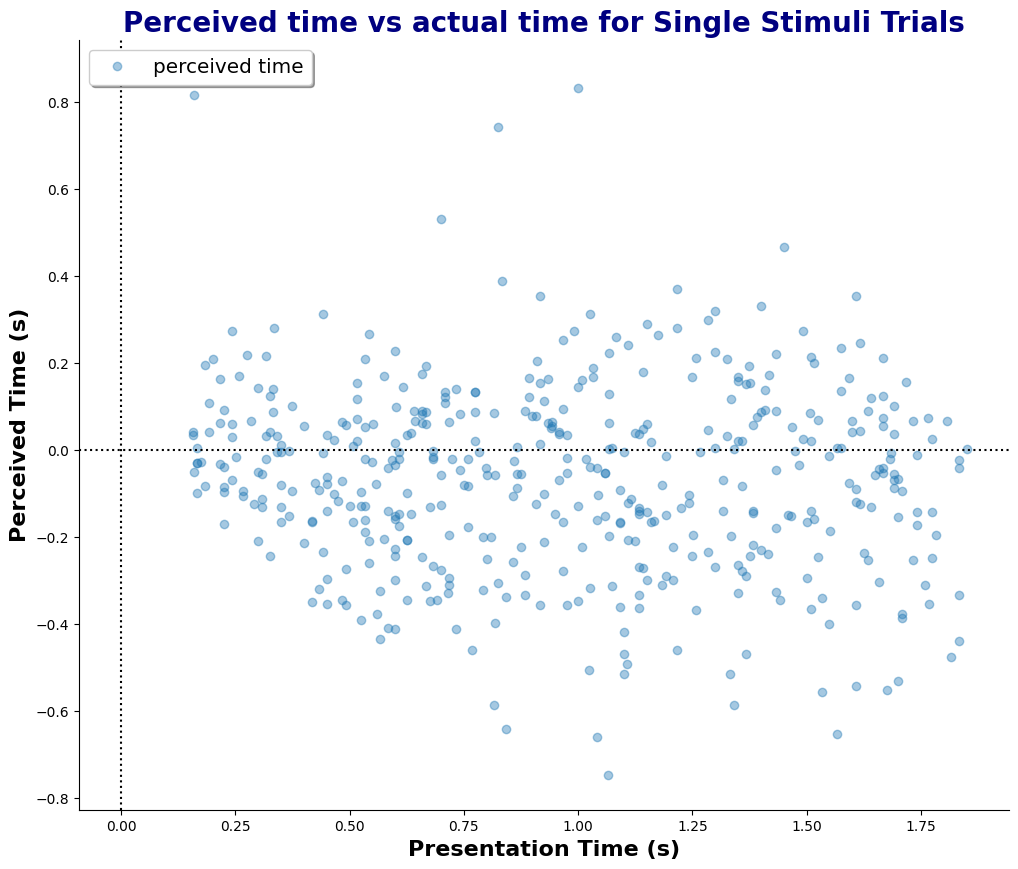

In [160]:
def plot_perceived_actual(df_trial):
    plt.figure(figsize=(12, 10))
    plt.plot(df_trial["target.started"],df_trial["pTemporalError"],'o',label="perceived time",alpha=0.4)
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #plt.axvline(x=2, color='black', linestyle='dotted')
    #plt.axhline(y=2, color='black', linestyle='dotted')
    plt.title("Perceived time vs actual time for Single Stimuli Trials", fontsize=20, fontweight='bold',c="Navy")
    plt.ylabel("Perceived Time (s)", fontsize=16, fontweight='bold')
    plt.xlabel("Presentation Time (s)", fontsize=16, fontweight='bold')
    # remove axis spines
    sns.despine()
    # add legend
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(datas_training)

## 1- Perceived time as a function of Presentation time

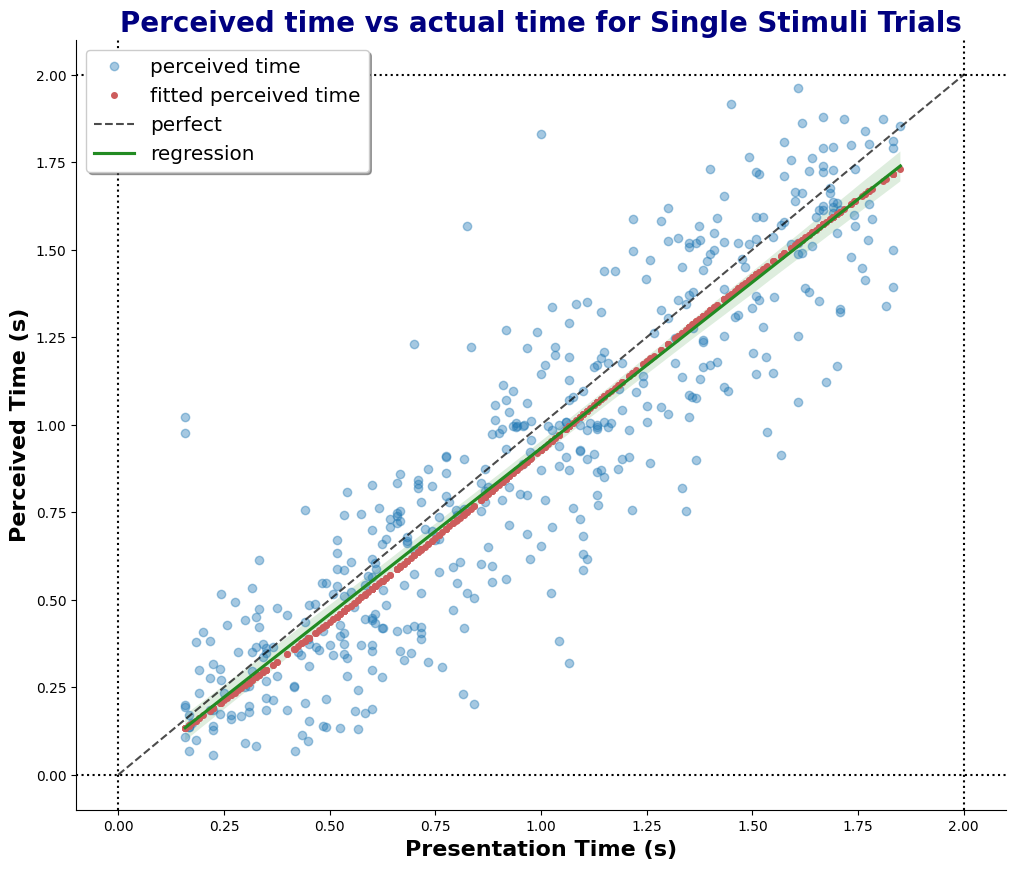

In [161]:
def plot_perceived_actual(df_trial):
    plt.figure(figsize=(12, 10))
    plt.plot(df_trial["target.started"],df_trial["perceivedTime"],'o',label="perceived time",alpha=0.4)
    plt.plot(df_trial["target.started"],df_trial["predictedPerceivedTime"],'ro',label="fitted perceived time",markersize=4,c="IndianRed",alpha=1)
    
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),label="perfect", c="black",linestyle='dashed',linewidth=1.5,alpha=0.7)
    sns.regplot(df_trial["target.started"],df_trial["perceivedTime"], x_ci="sd",label="regression",scatter=False,color="ForestGreen")
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axhline(y=2, color='black', linestyle='dotted')
    plt.title("Perceived time vs actual time for Single Stimuli Trials", fontsize=20, fontweight='bold',c="Navy")
    plt.ylabel("Perceived Time (s)", fontsize=16, fontweight='bold')
    plt.xlabel("Presentation Time (s)", fontsize=16, fontweight='bold')
    # remove axis spines
    sns.despine()
    # add legend
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(datas_training)

## 2.Overall Temporal Error

parameters of model 
[0.19473097 0.47025925 0.00415234]
 standard errors of the parameters 
[0.03080898 0.12951495 0.00377822]
parameters of model 
[3.34480328e+02 8.58571877e+02 1.12839488e-02]
 standard errors of the parameters 
[2.6205201e+08 6.7279422e+08 7.6436546e-03]
parameters of model 
[0.20978377 0.55980274 0.00485784]
 standard errors of the parameters 
[0.04781526 0.19364206 0.0035096 ]


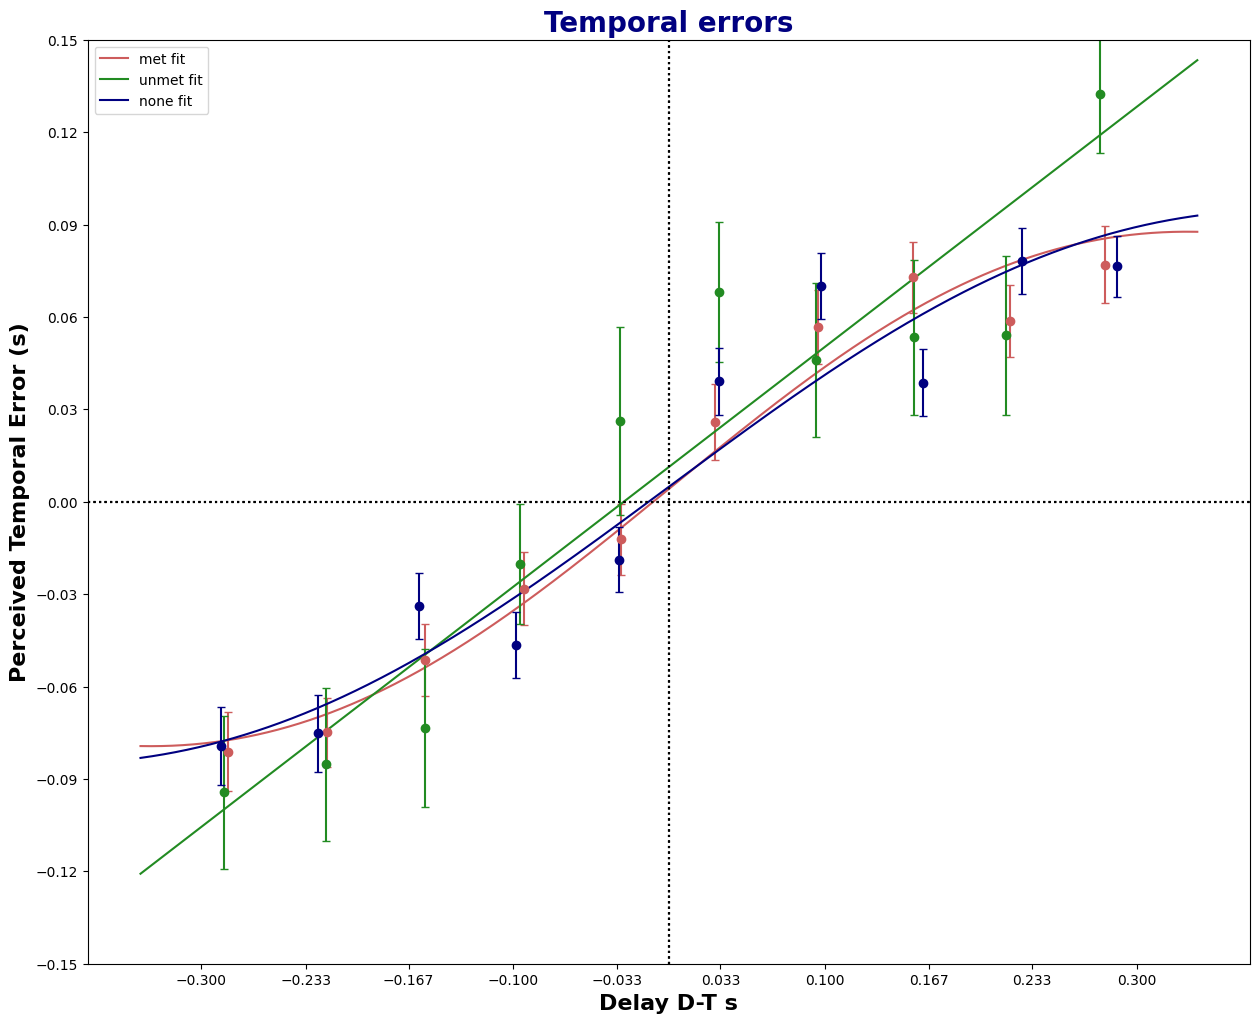

In [164]:
# Get meaans grouped by constant target-distractor delay
def get_medians(data):
    #df=clean_data(data=data_Erva)
    df_medians=data.groupby('delayS').mean()
    df_stdDev=data.groupby("delayS").std()
    #df_medians=data.groupby('subjID','delayS').median()
    #df_stdDev=data.groupby("subjID","delayS").std()
    # a=list(df_medians["delay"].unique())
    # a.sort()
    # df_medians["delayMs"]=a
    # del a
    #medX=df_medians["physicalDelay"]
    medX=df_medians["correctedDelay"]
    medY=df_medians["pTemporalErrorFitted"]
    
    # group the data by delayS and calculate the median and standard error of the median
    df_sem=data.groupby("delayS").sem()
    semY=df_sem["pTemporalErrorFitted"]
    #semY=list[semY]
    return medX, medY, semY
    
def modelPTime(delay,alpha,sigma,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/(sigma**2))+teta for x in delay]
    return modelPerceivedError

def model_time_base(delay,alpha,sigma):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/(sigma**2)) for x in delay]
    return modelPerceivedError

## plot the model
def plot_base_model(medians,df_trial,color):
    if medians==True:      xdata,ydata,semo=get_medians(df_trial)
    #else:        xdata,ydata=df_trial["physicalDelay"],df_trial["pTemporalErrorFitted"]
    else:        xdata,ydata=df_trial["correctedDelay"],df_trial["pTemporalErrorFitted"]
    medianX,mediansY,semo=get_medians(df_trial)

    parameters, covariance = curve_fit(modelPTime, xdata, ydata) # METHOD 1 - 3 parameters


    middleInt=np.linspace(-0.339,0.339,1000)
    fit_k = modelPTime(middleInt, parameters[0],parameters[1],parameters[2]) # METHOD 1 - 3 parameters
    
    
    ## Method 2
    #parameters, covariance = curve_fit(model_time_base, xdata, ydata) # METHOD 2 -2 parameters
    #fit_k = modelPTime(middleInt, parameters[0],parameters[1])#,parameters[2]) # Method 2 - 2 parameters

    # print the parameters and covariance
    print("parameters of model ")
    print(parameters)
    # calculate the standard errors of the parameters
    perr = np.sqrt(np.diag(covariance))
    print(" standard errors of the parameters ")
    print(perr)

    #plt.figure(figsize=(15, 12))
    # label most occuring congruency
    label=df_trial["congruency"].value_counts().index[0]
    #if medians==1:
    #plt.plot(medianX, mediansY, 'o',label=str(label)+' data',color=color)
    plt.errorbar(medianX,mediansY, yerr=semo, fmt='o', capsize=3,c=color)

    plt.plot(middleInt, fit_k, '-', label=str(label)+' fit',color=color)
    
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #sns.regplot(xdata, ydata, ci=None,label=str(label)+" regression")
    
    ### Plot by regression
    #sns.regplot(xdata,ydata, ci=None,label=str(label)+" regression",scatter=False,color=color)
    
    plt.title("Temporal errors",fontsize=20, fontweight='bold',c="Navy")
    plt.ylabel("Perceived Temporal Error (s)",fontsize=16, fontweight='bold')
    plt.xlabel("Delay D-T s",fontsize=16, fontweight='bold')
    ylim=0.15
    plt.ylim(-ylim,ylim)
    plt.yticks(list(np.linspace(-ylim,ylim,11)))
    plt.xticks(xAxisTicks)
    plt.legend()
    SE = np.sqrt(np.diag(covariance))
    SE_A , SE_B= SE[0], SE[1]
    #print(F'The value of A is {fit_A:.5f} with standard error of {SE_A:.5f}.')
    #print(F'The value of B is {fit_B:.5f} with standard error of {SE_B:.5f}.')
plt.figure(figsize=(15, 12))
plot_base_model(medians=0,df_trial=datas_test_met,color="IndianRed")
plot_base_model(medians=0,df_trial=datas_test_unmet,color="ForestGreen")
plot_base_model(medians=0,df_trial=datas_test_base,color="Navy")

# 3 - Reaction and Response Times

### 3.1 Response Time 

RT total for met data= 1.058345500001451
RT total for unmet data= 1.0917015499981062


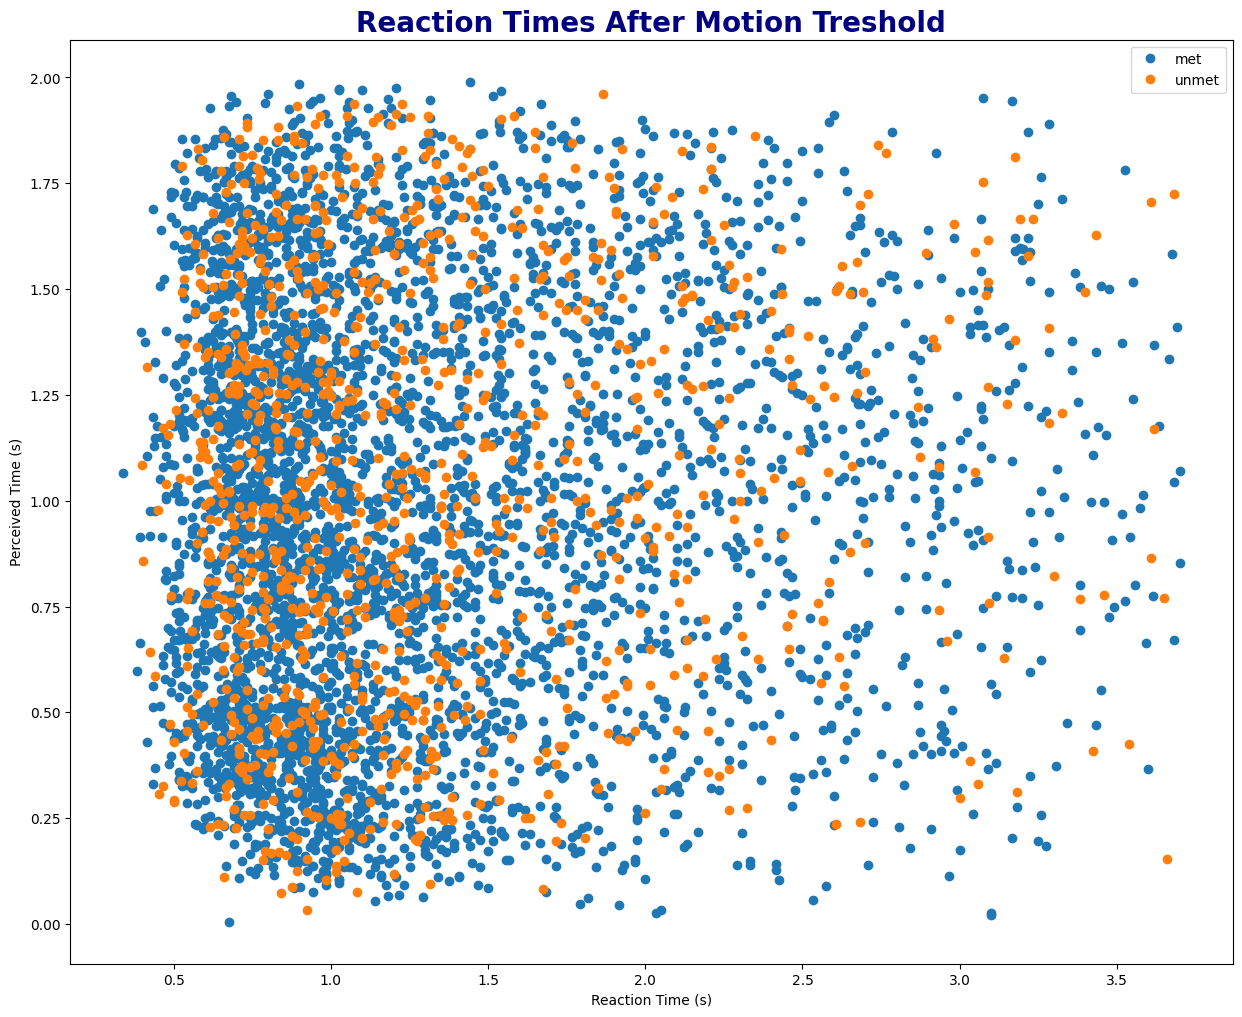

In [201]:

#remove outlier reaction times
def remove_outlier_for_time(data):
    rows_to_delete= data[np.abs(data["rTAfterMotionTreshold"])>5].index
    data = data.drop(rows_to_delete)
    mean_tmp, std_tmp=data["rTAfterMotionTreshold"].mean(), data["rTAfterMotionTreshold"].std()
    rows_to_delete_lower = data[data["rTAfterMotionTreshold"]>mean_tmp+3*std_tmp].index
    data = data.drop(rows_to_delete_lower)
    return data


df_test_met_time=remove_outlier_for_time(datas_test_met)
df_test_unmet_time=remove_outlier_for_time(datas_test_unmet)

print("RT total for met data= "+str(np.median(df_test_met_time["rTAfterMotionTreshold"])))
print("RT total for unmet data= "+str(np.median(df_test_unmet_time["rTAfterMotionTreshold"])))

plt.figure(figsize=(15, 12))
plt.plot(df_test_met_time["rTAfterMotionTreshold"],df_test_met_time["perceivedTime"],'o',label="met")
plt.plot(df_test_unmet_time["rTAfterMotionTreshold"],df_test_unmet_time["perceivedTime"],'o',label="unmet")
plt.title("Reaction Times After Motion Treshold", fontsize=20, fontweight='bold',c="Navy")
plt.ylabel("Perceived Time (s)")
plt.xlabel("Reaction Time (s)")
plt.legend()
#plt.xlim(0,2)

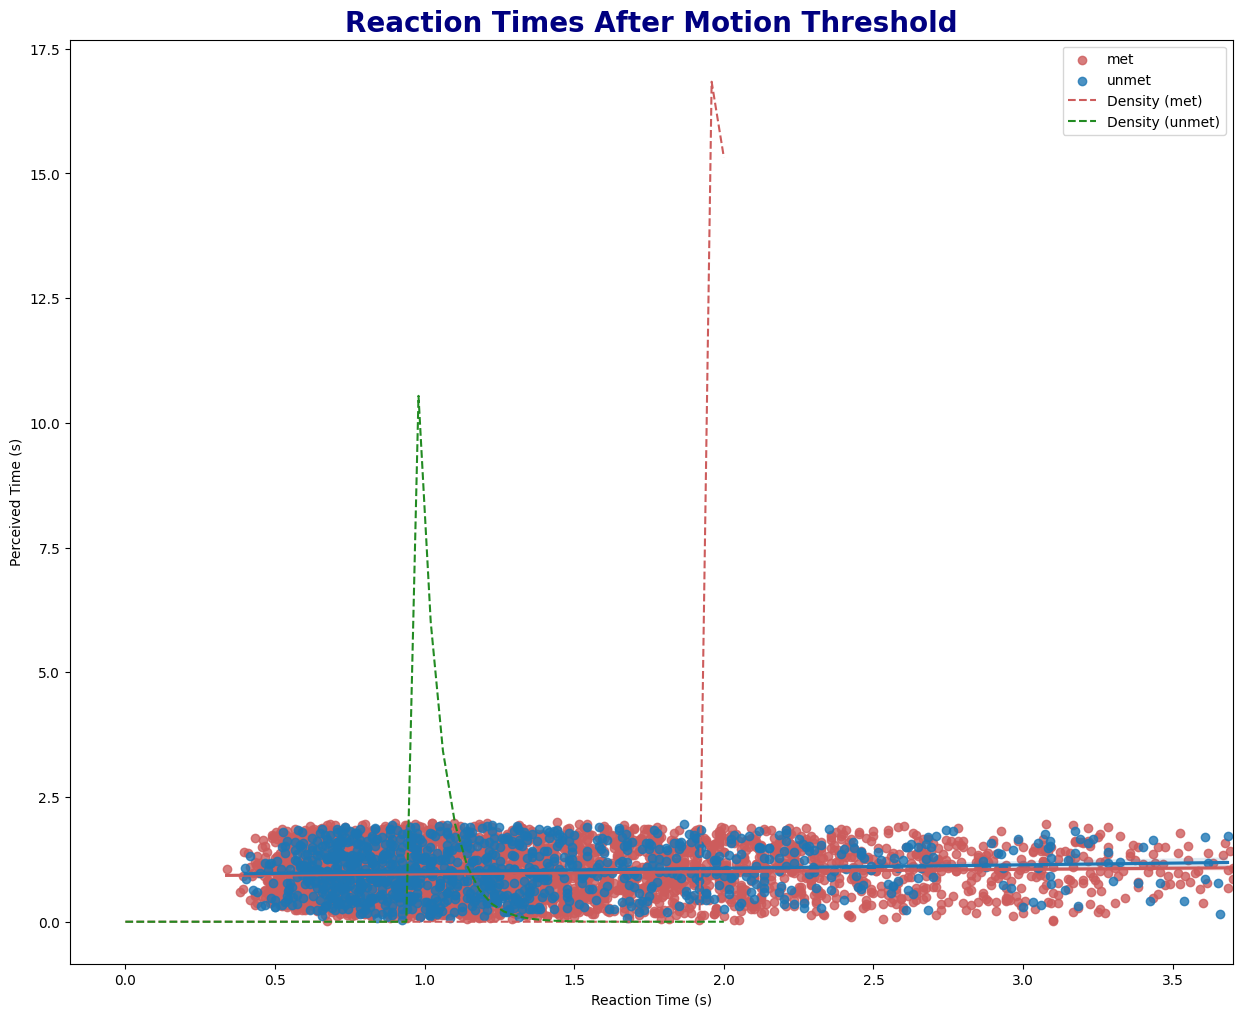

In [239]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, norm
from sklearn.mixture import GaussianMixture

# Define the ex-Gaussian distribution function
def exgauss(x, mu, sigma, tau):
    norm_pdf = norm.pdf(x, mu, sigma)
    expon_pdf = expon.pdf(x - mu, scale=tau)
    return norm_pdf * expon_pdf

# Set the number of bins for the density plot
num_bins = 50

# Plot scatter plot with trendlines
plt.figure(figsize=(15, 12))
sns.regplot(x=df_test_met_time["rTAfterMotionTreshold"], y=df_test_met_time["perceivedTime"], label="met", color="indianred")
sns.regplot(x=df_test_unmet_time["rTAfterMotionTreshold"], y=df_test_unmet_time["perceivedTime"], label="unmet")

# Perform ex-Gaussian fitting for met condition
gmm_met = GaussianMixture(n_components=2)
gmm_met.fit(df_test_met_time["rTAfterMotionTreshold"].values.reshape(-1, 1))
mu_met, sigma_met = gmm_met.means_.flatten()
tau_met = gmm_met.covariances_.flatten()[0]

# Perform ex-Gaussian fitting for unmet condition
gmm_unmet = GaussianMixture(n_components=2)
gmm_unmet.fit(df_test_unmet_time["rTAfterMotionTreshold"].values.reshape(-1, 1))
mu_unmet, sigma_unmet = gmm_unmet.means_.flatten()
tau_unmet = gmm_unmet.covariances_.flatten()[0]

# Generate x-values for the density plot
x = np.linspace(0, 2, num_bins)

# Calculate density values using the ex-Gaussian function
density_met = exgauss(x, mu_met, sigma_met, tau_met)
density_unmet = exgauss(x, mu_unmet, sigma_unmet, tau_unmet)

# Normalize the density values
density_met /= np.trapz(density_met, x)
density_unmet /= np.trapz(density_unmet, x)

# Plot density curves
plt.plot(x, density_met, label="Density (met)",color="indianred", linestyle="--")
plt.plot(x, density_unmet, label="Density (unmet)", color="ForestGreen", linestyle="--")

# Set plot title and labels
plt.title("Reaction Times After Motion Threshold", fontsize=20, fontweight='bold', c="Navy")
plt.xlabel("Reaction Time (s)")
plt.ylabel("Perceived Time (s)")

# Add legend and set plot limits
plt.legend()
#plt.xlim(0, 2)

plt.show()


AttributeError: 'function' object has no attribute 'fit'

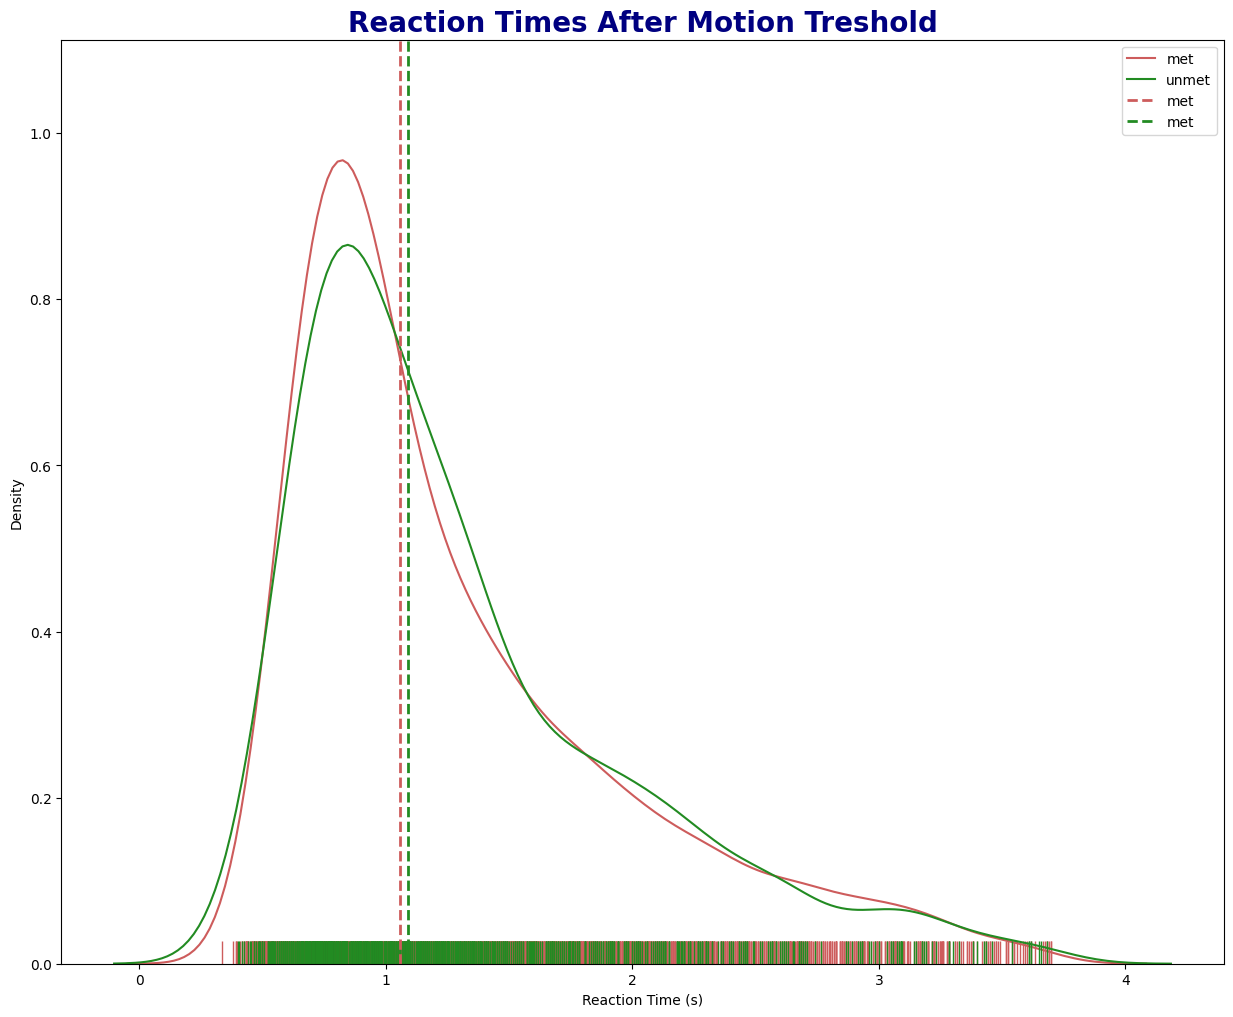

In [217]:
# create density plot for response times
plt.figure(figsize=(15, 12))
sns.distplot(df_test_met_time["rTAfterMotionTreshold"], hist=False, rug=True,label="met",color="IndianRed")
sns.distplot(df_test_unmet_time["rTAfterMotionTreshold"], hist=False, rug=True,label="unmet",color="ForestGreen")
    # indicate the mean
plt.axvline(x=np.median(df_test_met_time["rTAfterMotionTreshold"]), color='IndianRed', linestyle='dashed', linewidth=2,label="met")
plt.axvline(x=np.median(df_test_unmet_time["rTAfterMotionTreshold"]), color='ForestGreen', linestyle='dashed', linewidth=2,label="met")

plt.title("Reaction Times After Motion Treshold", fontsize=20, fontweight='bold',c="Navy")
plt.ylabel("Density")
plt.xlabel("Reaction Time (s)")
plt.legend()


# Ex-gaussian fit
def exgauss(x, mu, sigma, tau):
    """ExGaussian distribution."""
    return np.exp(-(x - mu) / tau) * norm.pdf((x - mu) / sigma) * (1 / sigma)

# fit ex-gaussian
def fit_exgauss(data):
    x = np.linspace(0, 5, 1000)
    params = exgauss.fit(data)
    print("mu = ", params[0])
    print("sigma = ", params[1])
    print("tau = ", params[2])
    plt.figure(figsize=(15, 12))
    plt.hist(data, bins=50, density=True)
    plt.plot(x, exgauss.pdf(x, *params), lw=3)
    plt.title("Ex-Gaussian fit", fontsize=20, fontweight='bold',c="Navy")
    plt.ylabel("Density")
    plt.xlabel("Reaction Time (s)")
    plt.show()

fit_exgauss(df_test_met_time["rTAfterMotionTreshold"])
fit_exgauss(df_test_unmet_time["rTAfterMotionTreshold"])

mu = 7.234674267772819
sigma = 0.5840594259232228
tau = 0.09780253434111685
mu = 6.876103560106883
sigma = 0.5975341496380339
tau = 0.10259875088710069


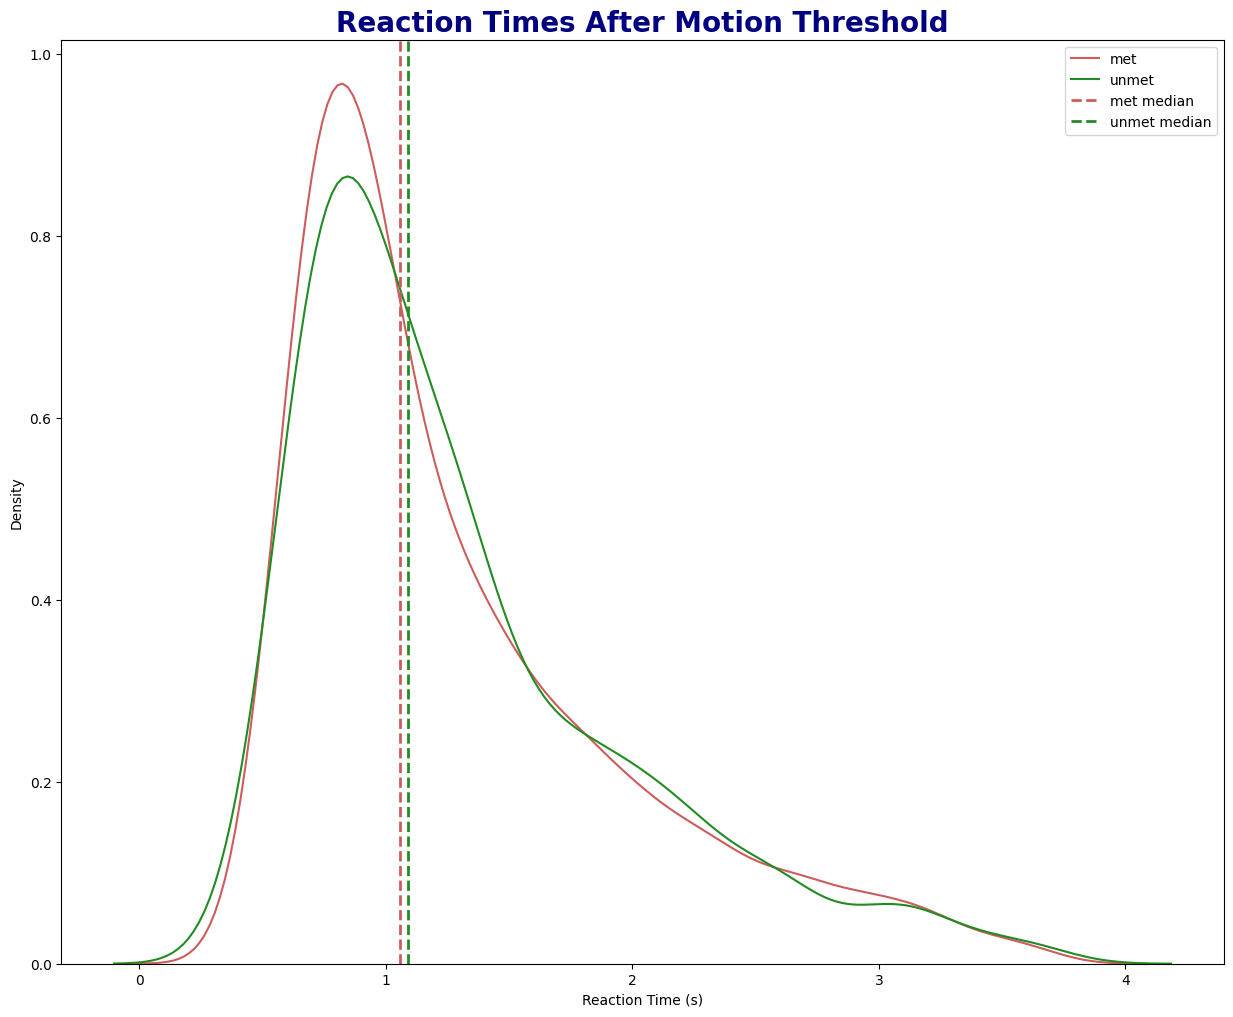

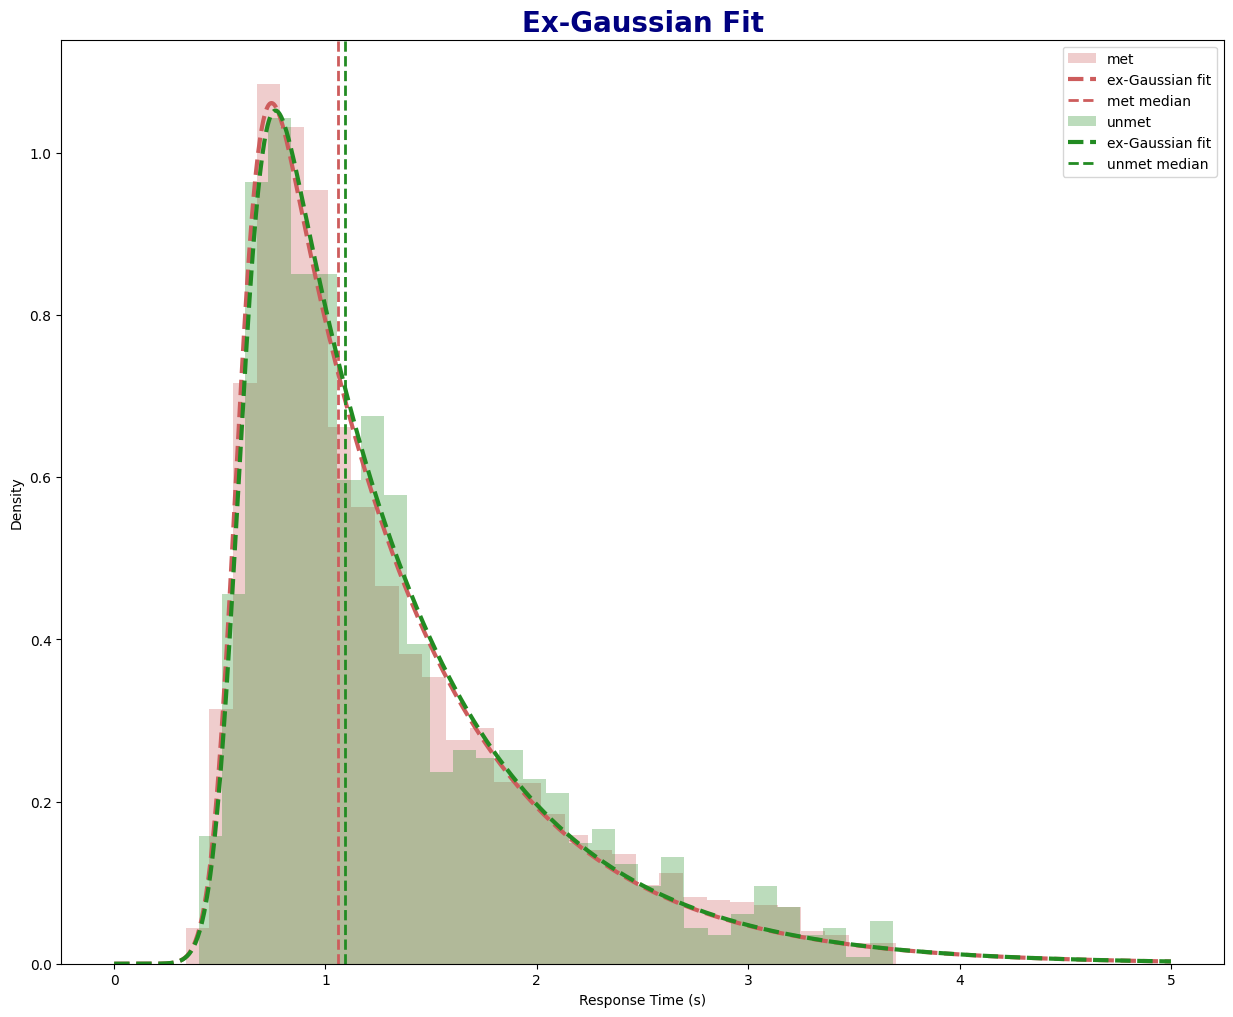

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import exponnorm

# Create density plot for response times
plt.figure(figsize=(15, 12))
sns.kdeplot(df_test_met_time["rTAfterMotionTreshold"], label="met", color="IndianRed")
sns.kdeplot(df_test_unmet_time["rTAfterMotionTreshold"], label="unmet", color="ForestGreen")
plt.axvline(x=np.median(df_test_met_time["rTAfterMotionTreshold"]), color='IndianRed', linestyle='dashed', linewidth=2, label="met median")
plt.axvline(x=np.median(df_test_unmet_time["rTAfterMotionTreshold"]), color='ForestGreen', linestyle='dashed', linewidth=2, label="unmet median")
plt.title("Reaction Times After Motion Threshold", fontsize=20, fontweight='bold', c="navy")
plt.xlabel("Reaction Time (s)")
plt.ylabel("Density")
plt.legend()

# Ex-Gaussian fit
def fit_exgauss(data, coloro, cong):
    params = exponnorm.fit(data)
    print("mu =", params[0])
    print("sigma =", params[1])
    print("tau =", params[2])
    x = np.linspace(0, 5, 1000)
    plt.hist(data, bins=30, density=True, color=coloro, alpha=0.3, label=cong)
    plt.plot(x, exponnorm.pdf(x, *params), lw=3, label="ex-Gaussian fit", color=coloro, # no label
             linestyle='--')
    # plor vertical line at medians
    plt.axvline(x=np.median(data), color=coloro, linestyle='dashed', linewidth=2, label=cong+" median")
    plt.title("Ex-Gaussian Fit", fontsize=20, fontweight='bold', c="navy")
    plt.xlabel("Response Time (s)")
    plt.ylabel("Density")
    # legend name is either met or unmet cong
    plt.legend()
    #plt.show()

plt.figure(figsize=(15, 12))

fit_exgauss(data=df_test_met_time["rTAfterMotionTreshold"],coloro="IndianRed",cong="met")
fit_exgauss(data=df_test_unmet_time["rTAfterMotionTreshold"],coloro="ForestGreen",cong="unmet")


### 3.2 Reaction Times - rtUntillMotionTreshold

RT total for met data= 0.0998011999981827
RT total for unmet data= 0.11584180000500055


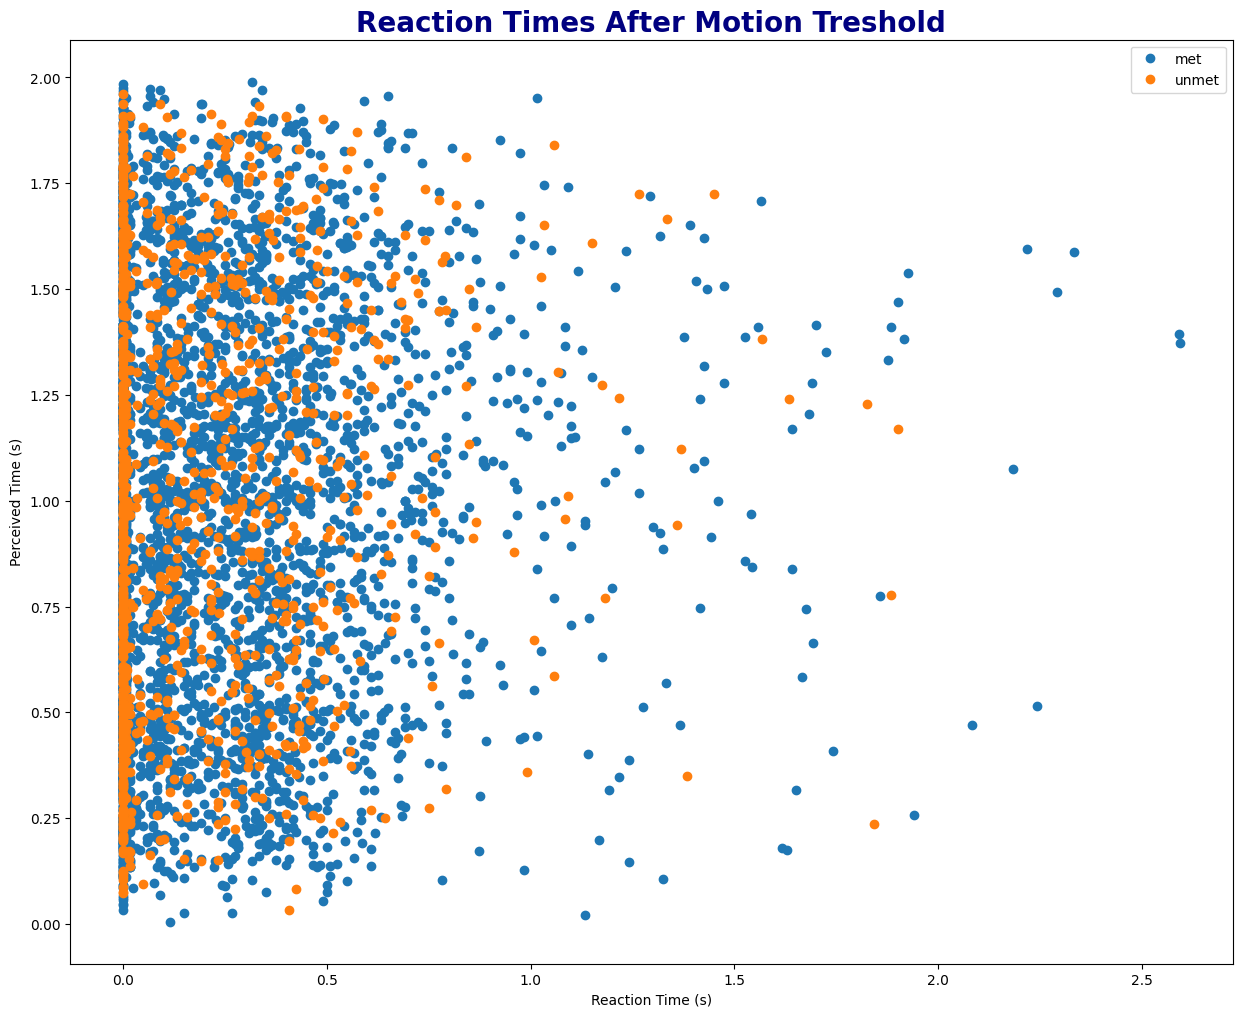

In [203]:
print("RT total for met data= "+str(np.median(df_test_met_time["rtUntillMotionTreshold"])))
print("RT total for unmet data= "+str(np.median(df_test_unmet_time["rtUntillMotionTreshold"])))
plt.figure(figsize=(15, 12))
plt.plot(df_test_met_time["rtUntillMotionTreshold"],df_test_met_time["perceivedTime"],'o',label="met")
plt.plot(df_test_unmet_time["rtUntillMotionTreshold"],df_test_unmet_time["perceivedTime"],'o',label="unmet")
plt.title("Reaction Times After Motion Treshold", fontsize=20, fontweight='bold',c="Navy")
plt.ylabel("Perceived Time (s)")
plt.xlabel("Reaction Time (s)")
plt.legend()
#plt.xlim(0,2)

KeyError: 'rtAfterMotionTreshold'

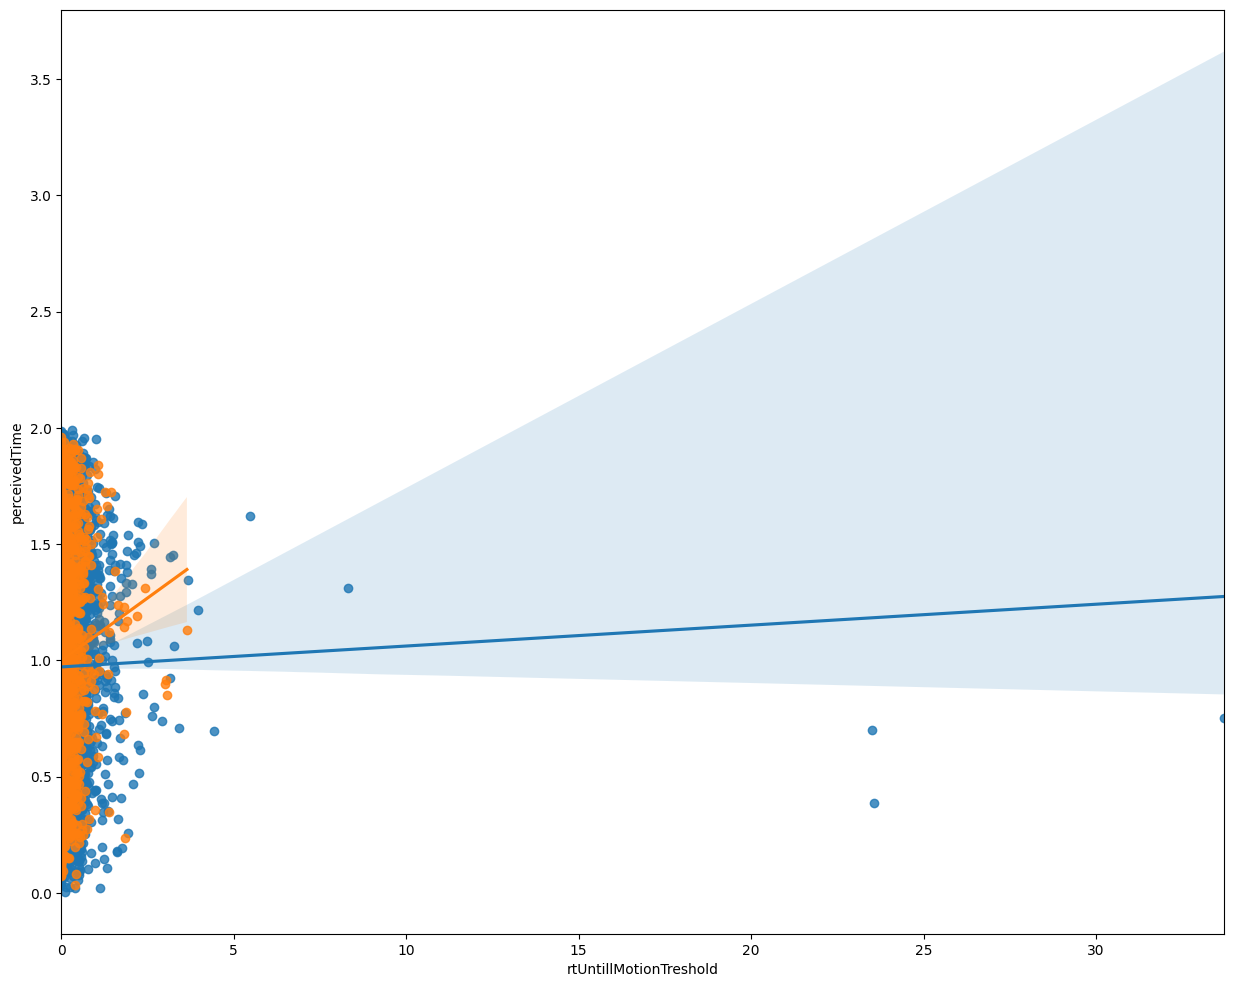

In [193]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Calculate median reaction times for met and unmet data
rt_met_median = np.median(datas_test_met["rtUntillMotionTreshold"])
rt_unmet_median = np.median(datas_test_unmet["rtUntillMotionTreshold"])

# Plot scatter plot with trendlines
plt.figure(figsize=(15, 12))
sns.regplot(x=datas_test_met["rtUntillMotionTreshold"], y=datas_test_met["perceivedTime"], label="met")
sns.regplot(x=datas_test_unmet["rtUntillMotionTreshold"], y=datas_test_unmet["perceivedTime"], label="unmet")

# Calculate and display correlation coefficients
corr_met, _ = pearsonr(datas_test_met["rtUntillMotionTreshold"], datas_test_met["rtA"])
corr_unmet, _ = pearsonr(datas_test_unmet["rtUntillMotionTreshold"], datas_test_unmet["perceivedTime"])
plt.text(1.8, 2.5, f"Corr (met): {corr_met:.2f}", fontsize=12)
plt.text(1.8, 2.4, f"Corr (unmet): {corr_unmet:.2f}", fontsize=12)

# Set plot title and labels
plt.title("Reaction Times After Motion Threshold", fontsize=20, fontweight='bold', c="Navy")
plt.xlabel("Reaction Time (s)")
plt.ylabel("Perceived Time (s)")

# Add legend and set plot limits
plt.legend()
plt.xlim(0, 2)

plt.show()


# 4 - Significance Test on Temporal Error

In [168]:
from scipy import stats
import numpy as np

delay_points = datas_test_expected["delayS"].unique()

for delay in delay_points:
    met_data = datas_test_expected[(datas_test_expected["congruency"] == "met") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    unmet_data = datas_test_expected[(datas_test_expected["congruency"] == "unmet") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    
    min_len = min(len(met_data), len(unmet_data))
    met_data = met_data[:min_len]
    unmet_data = unmet_data[:min_len]
    
    t_statistic, p_value = stats.ttest_rel(met_data, unmet_data)
    
    print(f"Delay: {delay}")
    print(f"Met Mean: {np.mean(met_data)}")
    print(f"Unmet Mean: {np.mean(unmet_data)}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print("")



Delay: 0.233
Met Mean: 0.11780404597621423
Unmet Mean: 0.04395261379394494
T-statistic: 2.604458408088797
P-value: 0.010839950274847375

Delay: 0.1
Met Mean: 0.05741512973166266
Unmet Mean: 0.033237110808750976
T-statistic: 0.6933943147824638
P-value: 0.48952367378440553

Delay: -0.233
Met Mean: -0.029454872413928468
Unmet Mean: -0.11888529654905217
T-statistic: 2.7276975648346826
P-value: 0.0077306244803482735

Delay: -0.3
Met Mean: -0.05473297592587368
Unmet Mean: -0.11342956018566787
T-statistic: 1.7647734443956145
P-value: 0.0804551628699481

Delay: 0.167
Met Mean: 0.04305946607201575
Unmet Mean: 0.029231128570893265
T-statistic: 0.3855939461864704
P-value: 0.7005353968670598

Delay: -0.033
Met Mean: 0.0028232277106209854
Unmet Mean: 0.0002204783137650272
T-statistic: 0.07402361368419048
P-value: 0.9411718746751687

Delay: 0.033
Met Mean: -0.011195242104958772
Unmet Mean: 0.04425497578598799
T-statistic: -1.937294479391917
P-value: 0.05571146677591311

Delay: -0.167
Met Mean: -0.04

In [172]:

# Perform independent samples t-test for each delay
for delay in delay_points:
    met_data = datas_test_expected[(datas_test_expected["congruency"] == "met") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    unmet_data = datas_test_expected[(datas_test_expected["congruency"] == "unmet") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    
    t_statistic, p_value = stats.ttest_ind(met_data, unmet_data)
    
    print(f"Delay: {delay}")
    print(f"Met Mean: {np.mean(met_data)}")
    print(f"Unmet Mean: {np.mean(unmet_data)}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print("")
    

Delay: 0.233
Met Mean: 0.05308929200014785
Unmet Mean: 0.04395261379394494
T-statistic: 0.31168061009163994
P-value: 0.7554046868366244

Delay: 0.1
Met Mean: 0.03397666941857335
Unmet Mean: 0.033237110808750976
T-statistic: 0.027447094624372916
P-value: 0.9781136461810755

Delay: -0.233
Met Mean: -0.09958336244484053
Unmet Mean: -0.11888529654905217
T-statistic: 0.6885552055075052
P-value: 0.49139728590731635

Delay: -0.3
Met Mean: -0.10487695186774168
Unmet Mean: -0.11342956018566787
T-statistic: 0.29283403417077974
P-value: 0.7697572916757272

Delay: 0.167
Met Mean: 0.06084988971948899
Unmet Mean: 0.029231128570893265
T-statistic: 1.2139318161882626
P-value: 0.22530637904746825

Delay: -0.033
Met Mean: -0.03136623927060296
Unmet Mean: 0.0002204783137650272
T-statistic: -1.044197825712879
P-value: 0.2968551096128816

Delay: 0.033
Met Mean: 0.011047444865492997
Unmet Mean: 0.04425497578598799
T-statistic: -1.15472103069819
P-value: 0.2487144734195613

Delay: -0.167
Met Mean: -0.0748173

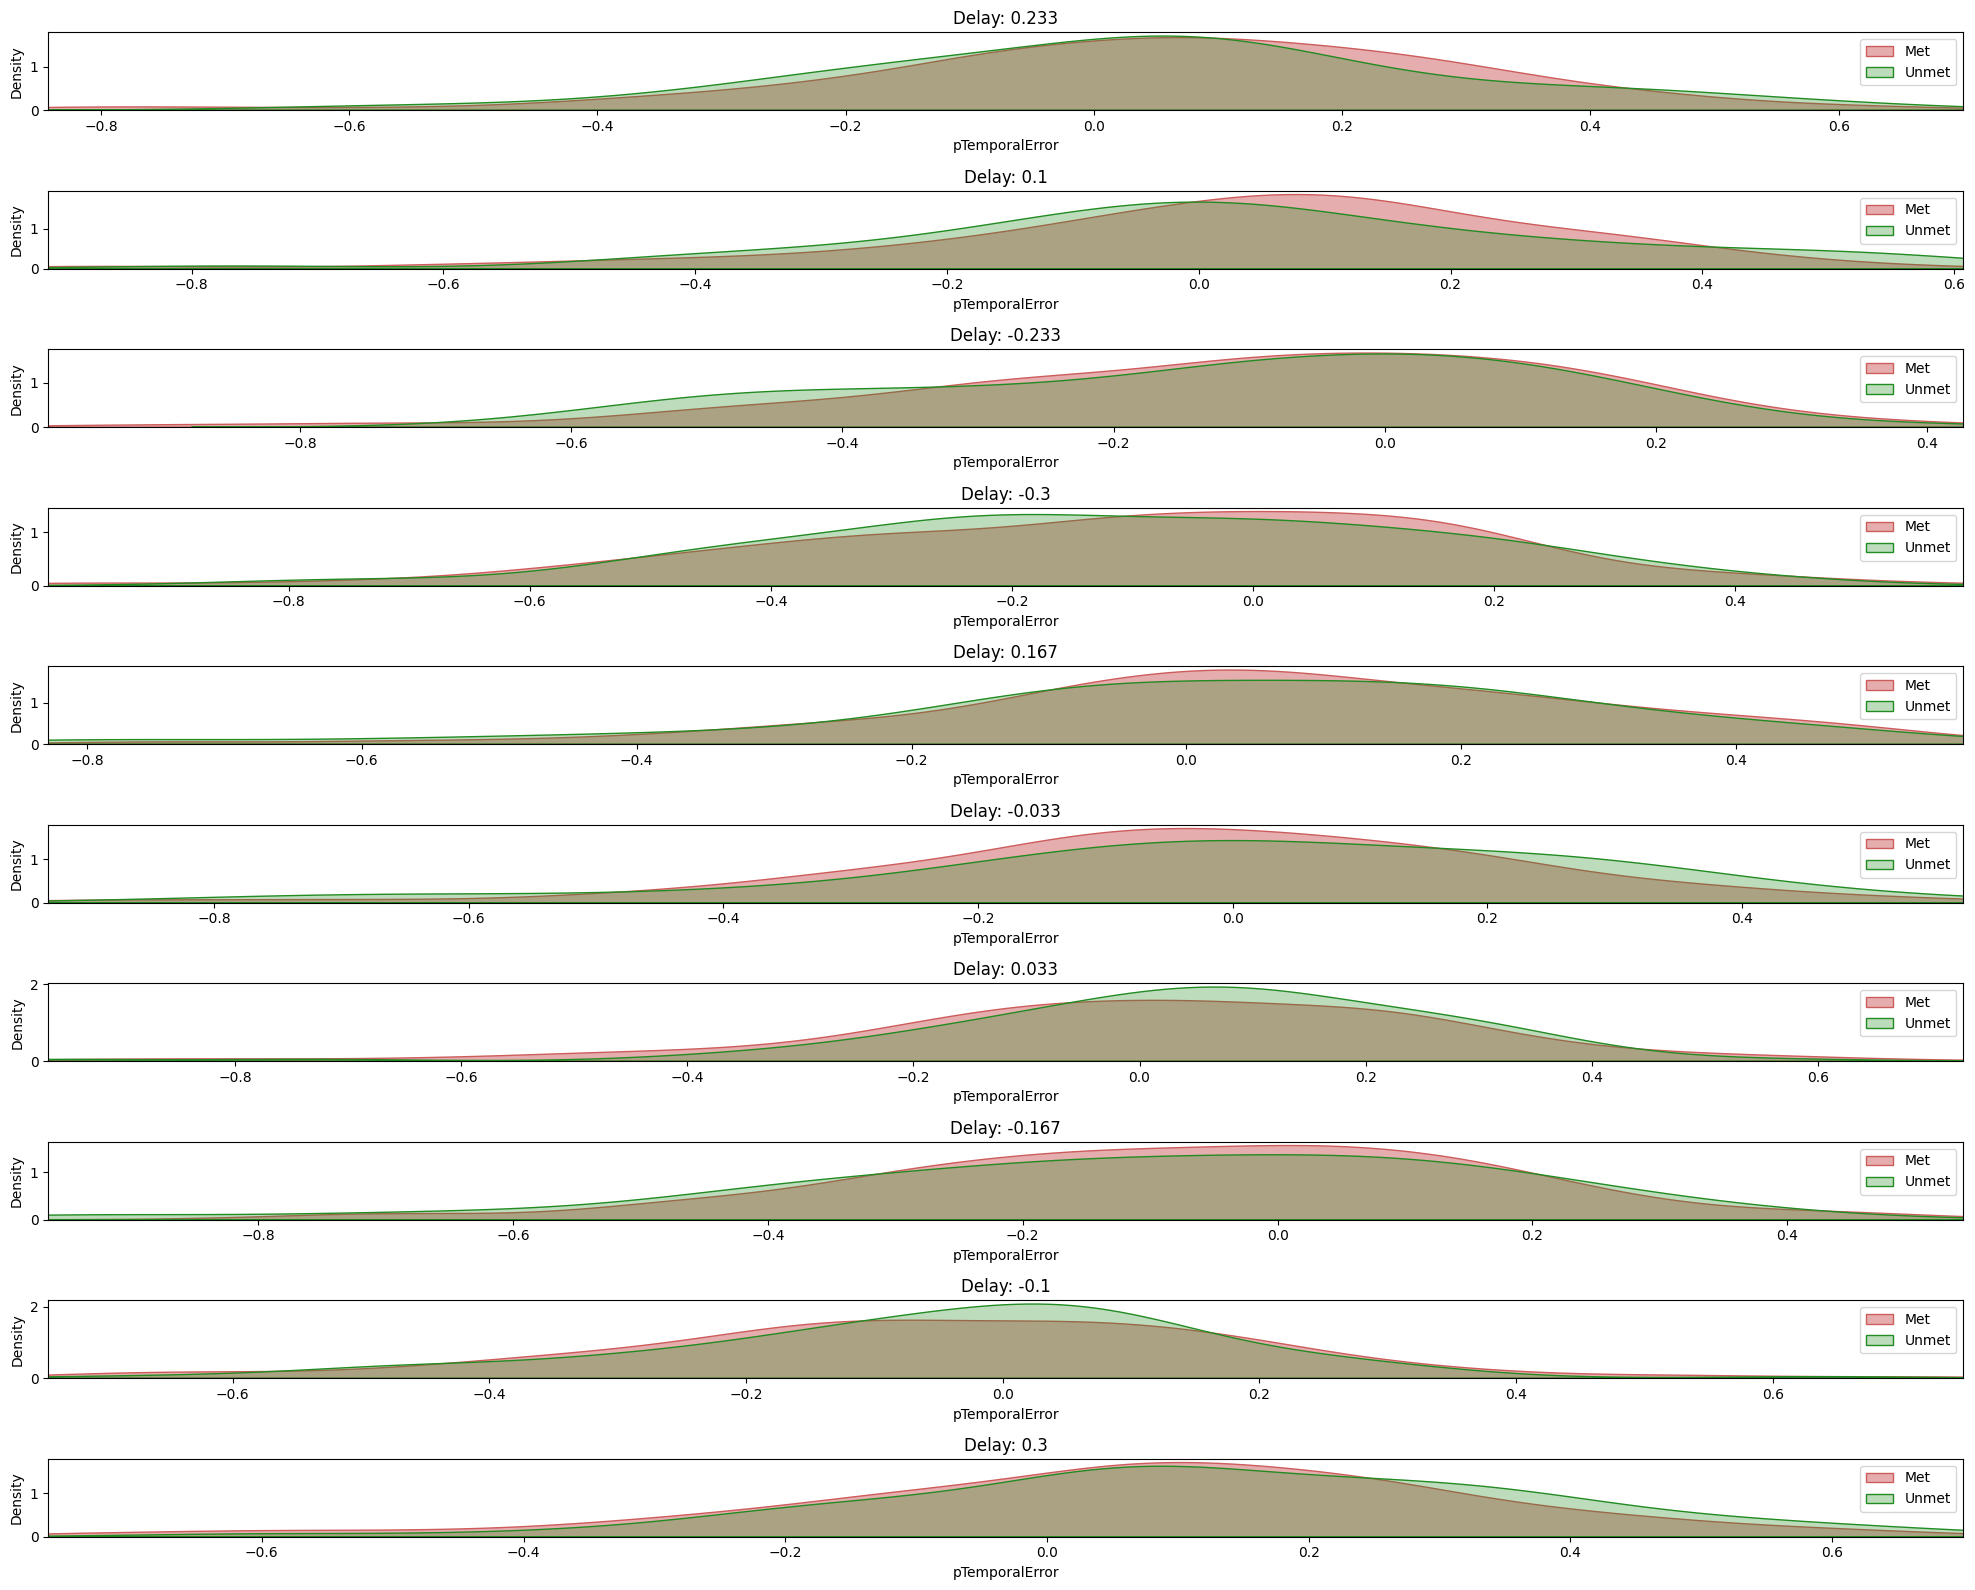

In [188]:
import matplotlib.pyplot as plt

# Create a subplot grid based on the number of delay points
num_delays = len(delay_points)
fig, axes = plt.subplots(num_delays, 1, figsize=(20, 16))

# Iterate through each delay point
for i, delay in enumerate(delay_points):
    met_data = datas_test_expected[(datas_test_expected["congruency"] == "met") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    unmet_data = datas_test_expected[(datas_test_expected["congruency"] == "unmet") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    
    # Select the appropriate subplot for the current delay
    ax = axes[i] if num_delays > 1 else axes
    
    # Plot the density distributions for "met" and "unmet" conditions
    #ax.hist(met_data, density=True, bins=20, alpha=0.5, label="Met")
    # also plot density line
    sns.kdeplot(met_data, shade=True, color="indianred", ax=ax, label="Met", alpha=0.5)
    #ax.hist(unmet_data, density=True, bins=20, alpha=0.5, label="Unmet")
    sns.kdeplot(unmet_data, shade=True, color="ForestGreen", ax=ax, label="Unmet", alpha=0.3)
    # limit the x-axis to the range of the data
    ax.set_xlim(min(min(met_data), min(unmet_data)), max(max(met_data), max(unmet_data)))

    # Set the subplot title and legend
    ax.set_title(f"Delay: {delay}")
    ax.legend()

# Adjust the spacing between subplots and display the plot
plt.tight_layout()
plt.show()


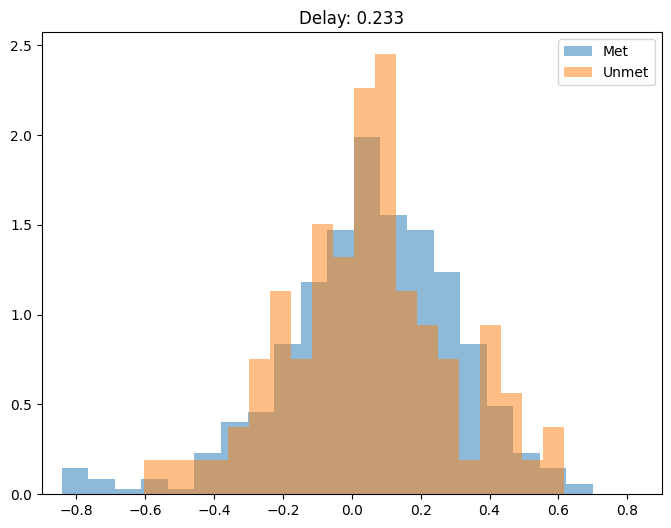

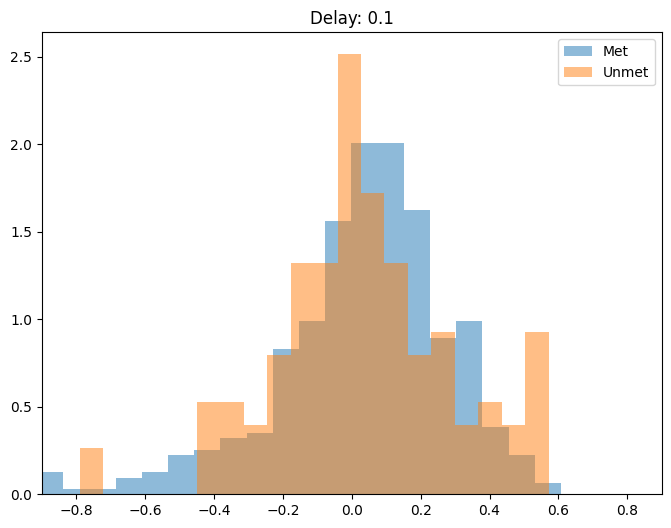

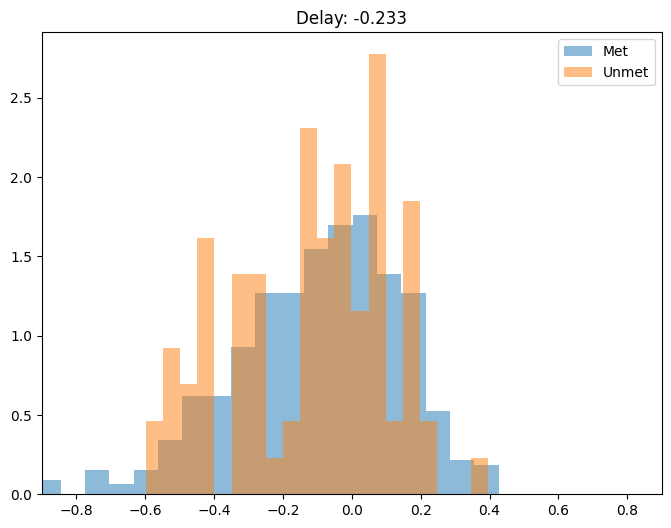

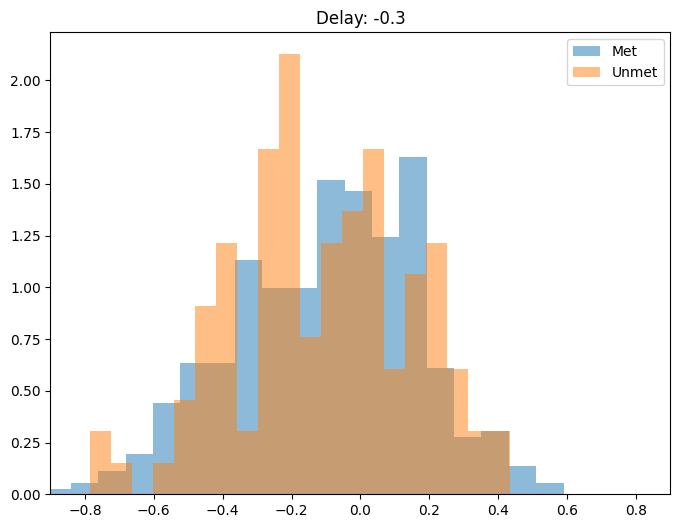

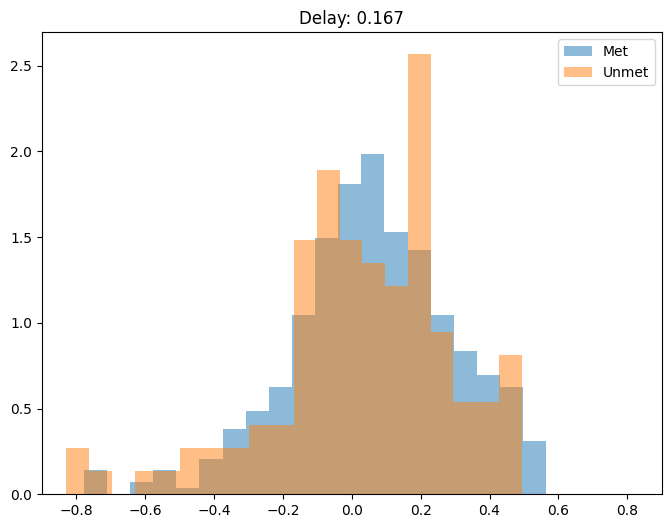

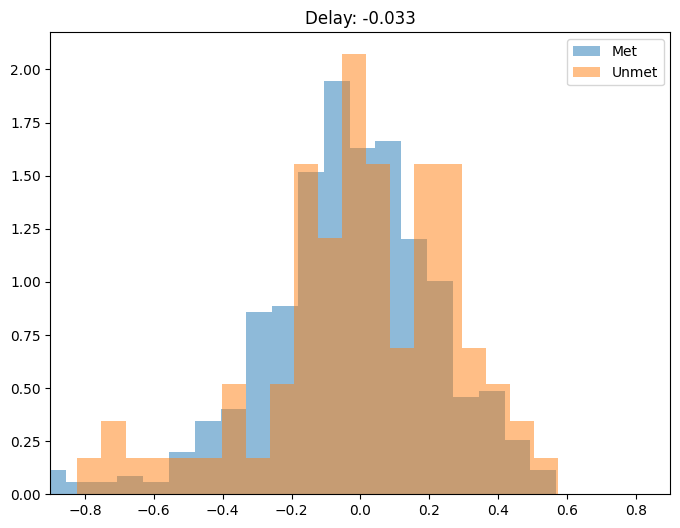

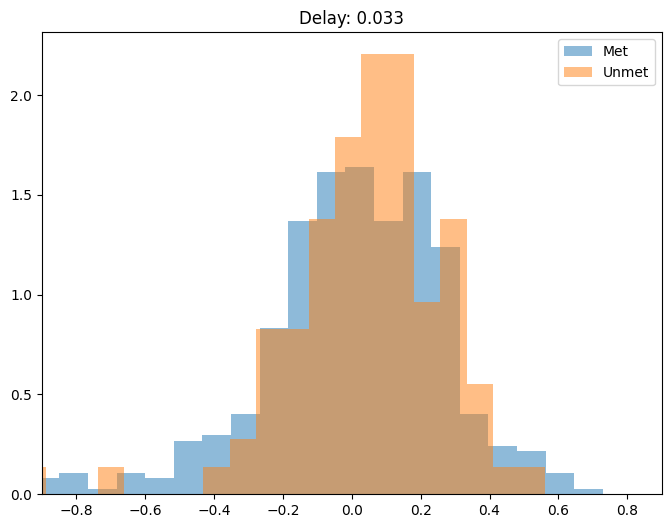

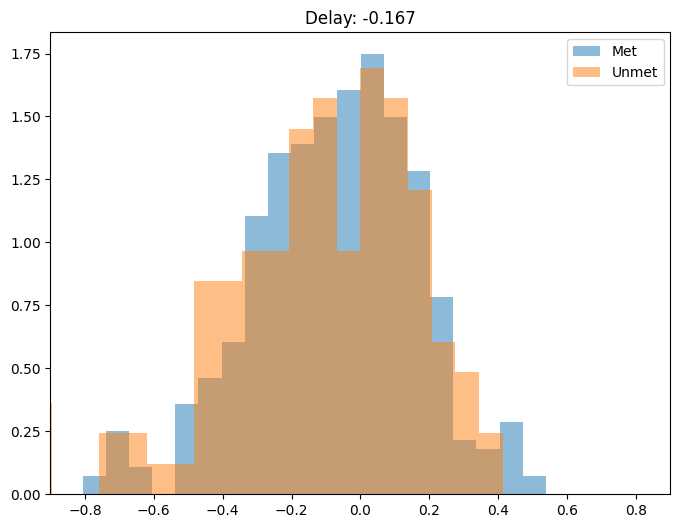

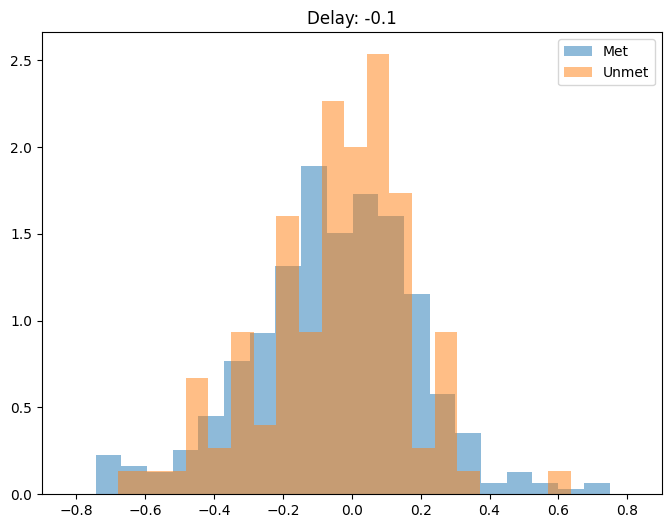

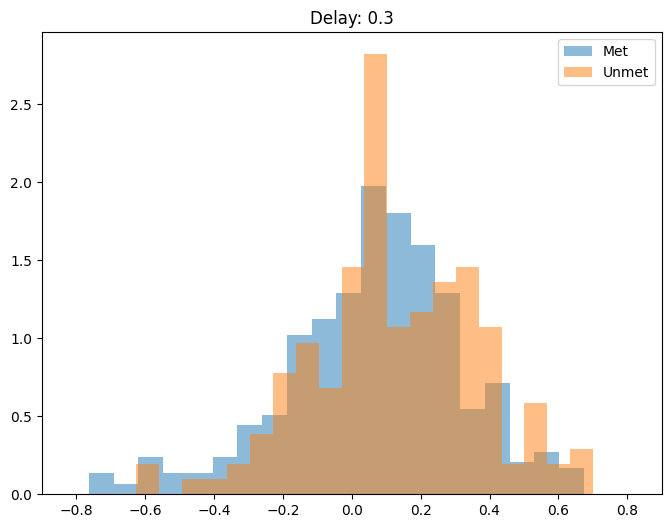

In [177]:
# PLot histogram density distributions of pTemporalError for each delay for met and unmet conditions in the same plot

for delay in delay_points:

    met_data = datas_test_expected[(datas_test_expected["congruency"] == "met") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    unmet_data = datas_test_expected[(datas_test_expected["congruency"] == "unmet") & (datas_test_expected["delayS"] == delay)]["pTemporalError"]
    
    plt.figure(figsize=(8, 6))
    plt.hist(met_data, density=True, bins=20, alpha=0.5, label="Met")
    plt.hist(unmet_data, density=True, bins=20, alpha=0.5, label="Unmet")
    plt.xlim(-0.9,0.9)
    plt.legend()
    plt.title(f"Delay: {delay}")
    plt.show()


In [166]:
# get descriptive statistics
datas_test_expected.groupby("congruency").describe()["pTemporalErrorFitted"]

,count,mean,std,min,25%,50%,75%,max
congruency,,,,,,,,
met,4361.0,0.003193,0.255999,-0.950997,-0.14626,0.021377,0.176599,0.769490
unmet,1072.0,0.015128,0.259947,-0.901893,-0.13896,0.035336,0.196336,0.689207


In [167]:
# write the data to a csv file
datas.to_csv("clean_all_data.csv", index=False)

In [131]:
import warnings
warnings.filterwarnings('ignore')
path="D:/analysis/data/"
p1_high="ahmed_high0_cont_expectation_shapes_perceived_time_2023-04-29_14h47.24.687.csv"
p1_train="ahmed_base01_expectation_shapes_perceived_time_2023-04-29_13h16.43.447.csv"

# df=pd.read_csv(path+p1_high)
# df_train=pd.read_csv(path+p1_train)
# df=clean_data(df)
df,df_train=predictedPerceivedTime(datas,None)
df.head()
df=outlier_remover(df,"pTemporalError")


TypeError: ignored

In [ ]:
datas=datas[datas["target.started"].notna()]
datas=datas[datas["perceivedTime"].notna()]
df_test=datas[datas["isTrial"]=="testSingleStim"]
##### fit data to model
df_tmp=df_test
## Remove the outliers
df_tmp=outlier_remover(df_tmp,"pTemporalError")
## fit model to to perceived time
x=datas["target.started"]
x=x.astype(float)
y=datas["perceivedTime"]
y=y.astype(float)
parameters, covariance = curve_fit(modelPerceivedTime2, x,y)
fit_A , fit_B = parameters[0] , parameters[1]
preditcedPerceivedTime = modelPerceivedTime2(df["target.started"], fit_A, fit_B)
## assign new variables to df
datas["predictedPerceivedTime"]=preditcedPerceivedTime # take fitted perceived time to the data
datas["pTemporalErrorFitted"]=datas["perceivedTime"]-datas["predictedPerceivedTime"] # calculate temporal error based on predicted time

avgError=np.mean(df_test["perceivedTime"]-df_test["target.started"])
datas["pTemporalErrorAvaraged"]=datas["pTemporalError"]-avgError
## assign datas to self
datas=datas[datas["pTemporalError"].notna()]
df_trial=datas[datas["isTrial"]=="trial"]
df_trial=datas
df_long=df

df_unmet=datas[datas["congruency"]=="unmet"]
df_met=datas[datas["congruency"]=="met"]

NameError: name 'modelPerceivedTime2' is not defined

In [ ]:
datas.to_csv("datas.csv")

In [ ]:
# Get meaans grouped by constant target-distractor delay
def get_medians(data):
    #df=clean_data(data=data_Erva)
    df_medians=data.groupby('delayS').median()
    df_stdDev=data.groupby("delayS").std()
    a=list(df_medians["delay"].unique())
    a.sort()
    df_means["delayMs"]=a
    del a
    xdata=df_means["physicalDelay"]
    ydata=df_means["pTemporalErrorFitted"]
    return xdata, ydata

In [ ]:

def model_time_base(delay,alpha,sigma):
	modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2) for x in delay]
	return modelPerceivedError
def modelPTime(delay,alpha,sigma,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+teta for x in delay]
    return modelPerceivedError
def model_expectation_met(delay,alpha,sigma,delta,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**4)+teta for x in delay]
    return modelPerceivedError
def model_expectation_unmet(delay,alpha,sigma,teta,delta=1):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**5)+teta for x in delay]
    return modelPerceivedError    


## fit model to to perceived time

KeyError: 'predictedPerceivedTime'

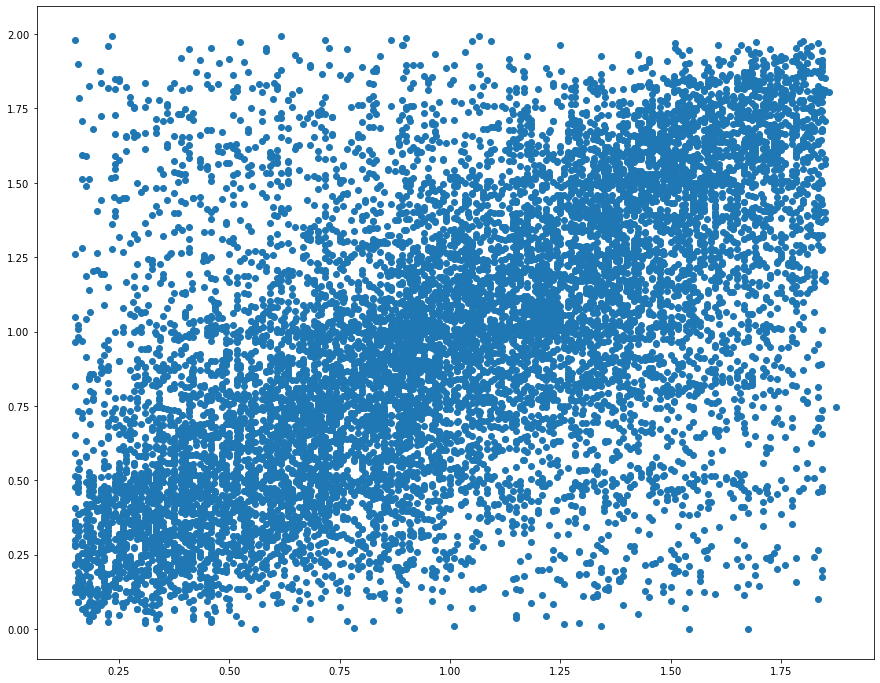

In [ ]:
def modelPerceivedTime(x,alpha,beta):
    return alpha*np.sin(1*math.pi*x)+beta*x

def plot_perceived_actual(df_trial):
    plt.figure(figsize=(15, 12))
    plt.plot(datas["target.started"],datas["perceivedTime"],'o',label="perceived time")
    plt.plot(datas["target.started"],datas["predictedPerceivedTime"].astype(float),'ro',label="fitted perceived time")
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),label="perfect")
    #sns.regplot(datas["target.started"],datas["perceivedTime"].astype, ci=None,label="regression")
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axhline(y=2, color='black', linestyle='dotted')
    #plt.title("Perceived time vs actual time for Test trials of "+datas.split('_')[0])
    plt.ylabel("Perceived Time (s)")
    plt.xlabel("Actual Time (s)")
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(datas)

In [ ]:
fitter()

In [ ]:
mets=fitter(means=0,congruency="met",dfi=datas)
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=fitter(means=0,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])
#a.plotter(x,fit_y,xdata,ydata,congruency
def plot_mets_unmets(mets,unmets):
    plt.figure(figsize=(15, 12))
    plt.plot(mets[2], mets[3], 'o', label='met data',color='red')
    plt.plot(unmets[2], unmets[3], 'o', label='unmet data',color='green')

    plt.plot(mets[0], mets[1], '-', label='met fit',color='red')
    plt.plot(unmets[0], unmets[1], '-', label='unmet fit',color='green')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #sns.regplot(xdata, ydatak, ci=None,label="regression")
    #plt.title("Temporal errors of "+df_obj.data_name.split('_')[0]+" met vs unmet")
    plt.ylabel("Perceived Temporal Error (s)")
    plt.xlabel("Delay D-T s")
    lim=0.4
    plt.ylim(-lim, +lim)
    plt.yticks(list(np.linspace(-lim,lim,11)))
    #plt.yticks(10)
    plt.xticks(xAxisTicks)
    plt.legend()
    plt.show()

mets=fitter(means=1,congruency="met")
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=fitter(means=1,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])  
plot_mets_unmets(mets,unmets)
mets=fitter(means=0,congruency="met")
#df_obj.plotter(mets[0],mets[1],mets[2],mets[3],mets[4])
unmets=fitter(means=0,congruency="unmet")
#df_obj.plotter(unmets[0],unmets[1],unmets[2],unmets[3],unmets[4])
plot_mets_unmets(mets,unmets)

NameError: name 'fitter' is not defined

In [ ]:
def plot_base_model(means,plotly=False):
    if means==True:
        xdata,ydata=get_means(df_trial)
    else:
        xdata,ydata=df_trial["physicalDelay"],df_trial["pTemporalErrorFitted"]
    #parameters, covariance = curve_fit(model_time_base, xdata, ydata)
    parameters, covariance = curve_fit(modelPTime, xdata, ydata)
    fit_A, fit_B = parameters[0], parameters[1]
    #print(fit_A,fit_B)
    middleInt=np.linspace(-0.35,0.35,100)
    fit_k = modelPTime(middleInt, fit_A, fit_B,parameters[2])
    ## Plot using matplotlib
    plt.figure(figsize=(15, 12))
    plt.plot(xdata, ydata, 'o', label='data')
    plt.plot(middleInt, fit_k, '-', label='fit')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    sns.regplot(xdata, ydata, ci=None,label="regression")
    #plt.title("Temporal errors of "+data_name.split('_')[0])
    plt.ylabel("Perceived Temporal Error (s)")
    plt.xlabel("Delay D-T s")
    plt.ylim(-0.4,0.4)
    plt.yticks(list(np.linspace(-0.4,0.4,11)))
    plt.xticks(xAxisTicks)
    plt.legend()
    SE = np.sqrt(np.diag(covariance))
    SE_A , SE_B= SE[0], SE[1]
    #print(F'The value of A is {fit_A:.5f} with standard error of {SE_A:.5f}.')
    #print(F'The value of B is {fit_B:.5f} with standard error of {SE_B:.5f}.')

def fitter(means=1,congruency="met",dfi=datas):
    df=dfi
    df_to_fit=df[df["congruency"]==congruency]
    df_to_fit=df[df["pTemporalError"]<2]
    df_to_fit=df[df["pTemporalError"]>-2]
    #df_to_fit=outlier_remover(df_to_fit,"pTemporalError")
    if means==True:  xdata,ydata=get_means(df)
    else:  xdata,ydata=df["physicalDelay"],df["pTemporalErrorFitted"]
    x=x=np.linspace(min(xdata),max(xdata),200)
    if congruency=="met":   
        params, covariance = curve_fit(model_expectation_met, xdata.astype(float), ydata.astype(float))
        fited_errors = model_expectation_met(x, params[0],params[1],params[2],params[3])
    else:
        params, covariance = curve_fit(model_expectation_unmet, xdata, ydata,maxfev=2000)
        fited_errors = model_expectation_unmet(x, params[0],params[1],params[2],params[3])
    fit_alpha,fit_sigma,fit_teta= params[0],params[1],params[2]
    np.sqrt(np.diag(covariance))
    print(np.sqrt(np.diag(covariance)))
    print("for "+congruency+" condition fit alpha is :" +str(fit_alpha)+" fit sigma is :"+str(fit_sigma)+"fit teta : "+ str(fit_teta))
    return x,fited_errors,xdata,ydata,congruency
def plotter(x,fit_y,xdata,ydata,congruency,df=datas):
    plt.figure(figsize=(15, 12))
    plt.plot(xdata, ydata, 'o', label='data')
    plt.plot(x, fit_y, '-', label='fit')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #sns.regplot(xdata, ydatak, ci=None,label="regression")
    plt.title("Temporal errors of "+data_name.split('_')[0]+congruency+" trials")
    plt.ylabel("Perceived Temporal Error (s)")
    plt.xlabel("Delay D-T s")
    plt.ylim(-0.3, +0.3)
    plt.yticks(list(np.linspace(-0.35,0.35,11)))
    #plt.yticks(10)
    plt.xticks(xAxisTicks)
    plt.legend()

def perceived_actual(data):
    plt.figure(figsize=(15, 12))
    y=df_trial["perceivedTime"]
    x=df_trial["target.started"]
    plt.plot(x,y,'o')
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100))
    sns.regplot(x, y, ci=None)
    
    